In [302]:
import pandas as pd
from pandas import pivot
from sklearn.linear_model import LinearRegression

# Define the word groups
categories = {
    'Me': ['I', 'myself', 'my', 'mine', 'self'],
    'Not me': ['they', 'them', 'their', 'theirs', 'other'],
    'Death': ['die', 'funeral', 'deceased', 'lifeless', 'suicide'],
    'Life': ['alive', 'survive', 'thrive', 'breathing', 'live']
}

In [303]:
# Function to categorize 'Stim'
def categorize_stim(stim):
    for category, words in categories.items():
        if stim in words:
            return category
    return 'Unknown'  # In case the word does not match any category

# Create the 'Match' column based on 'Category' and 'BlockType'
def match_category(row):
    if row['BlockType'] == 'life-me':
        if row['Category'] in ['Life', 'Me']:
            return 1
    elif row['BlockType'] == 'death-me':
        if row['Category'] in ['Death', 'Me']:
            return 1
    return 0

# Create the 'Type' column where 'life-me' is mapped to 1 and 'death-me' to 2
def map_type(block_type):
    if block_type == 'life-me':
        return 1
    elif block_type == 'death-me':
        return 2
    return 0

In [304]:
import os
import re

mdd_dir = '/Users/applepie/Library/CloudStorage/OneDrive-WorcesterPolytechnicInstitute(wpi.edu)/toi4_new 2/mdd'
mdd_paths = [('mdd', f'{mdd_dir}/{subject}/1/') for subject in os.listdir(mdd_dir) if subject.startswith('3') or subject.startswith('2')]

ctl_dir = '/Users/applepie/Library/CloudStorage/OneDrive-WorcesterPolytechnicInstitute(wpi.edu)/ctl'
ctl_paths = [('ctl', f'{ctl_dir}/{subject}/1/') for subject in os.listdir(ctl_dir) if subject.startswith('3') or subject.startswith('2')]

paths = mdd_paths + ctl_paths
subject_df = pd.DataFrame()
for i, (subject_type, path) in enumerate(paths):
    subject_id = path[-6:-3]
    # disregard outlier
    if subject_id == '209':
        continue
        
    filenames = os.listdir(path)
    csv_filename = [filename for filename in filenames if re.search('toi4iat.*metrics.csv$', filename)][0]
    point = pd.read_csv(f'{path}/{csv_filename}')
    point['subject_type'] = subject_type
    point['subject_id'] = subject_id
    subject_df = pd.concat([subject_df, point], ignore_index=True)
    
subject_df = subject_df[subject_df['BlockNumber'] >= 0] 
subject_df = subject_df[subject_df['ResponseTime'] > 0]

subject_df['Category'] = subject_df['Stim'].apply(categorize_stim)
subject_df['Match'] = subject_df.apply(match_category, axis=1)
subject_df

,BlockNumber,BlockType,TrialNum,Stim,Response,ResponseTime,subject_type,subject_id,Category,Match
10,0,life-me,12,mine,1,972,mdd,307,Me,1
11,0,life-me,13,I,1,1058,mdd,307,Me,1
12,0,life-me,14,myself,1,721,mdd,307,Me,1
13,0,life-me,15,suicide,1,1023,mdd,307,Death,0
14,0,life-me,16,my,1,1333,mdd,307,Me,1
...,...,...,...,...,...,...,...,...,...,...
5325,17,life-me,367,self,1,748,ctl,310,Me,1
5326,17,life-me,368,alive,1,756,ctl,310,Life,1
5327,17,life-me,369,their,1,607,ctl,310,Not me,0
5328,17,life-me,370,myself,1,657,ctl,310,Me,1


In [305]:
block_counts = subject_df.groupby(['subject_id'])['BlockNumber'].nunique()
subjects_to_keep = block_counts[block_counts > 6].index
filtered_df = subject_df[subject_df['subject_id'].isin(subjects_to_keep)]
mean_rt = filtered_df.groupby(['subject_id', 'Match', 'subject_type', 'BlockNumber'])['ResponseTime'].mean().reset_index(name='ResponseTime')
index_columns = ['subject_id', 'Match', 'subject_type']
pivot_df = mean_rt.pivot_table(index=index_columns, columns=mean_rt.groupby(index_columns).cumcount(), values='ResponseTime')

In [306]:
from sklearn.decomposition import PCA

projected_points = PCA(n_components=2).fit_transform(pivot_df)
projected_df = pd.DataFrame(projected_points, index=pivot_df.index, columns=['PC1', 'PC2']).reset_index()
projected_df

,subject_id,Match,subject_type,PC1,PC2
0,301,0,ctl,-278.983187,153.755053
1,301,1,ctl,-386.824053,309.073637
2,304,0,ctl,-62.255332,66.358020
3,304,1,ctl,-242.363928,28.258034
4,306,0,mdd,-429.390183,-114.054771
5,306,1,mdd,-507.185058,-208.329520
6,307,0,mdd,830.218968,-222.738378
7,307,1,mdd,742.545958,-75.980908
8,308,0,mdd,316.361158,-205.163474
9,308,1,mdd,51.772737,-361.970336


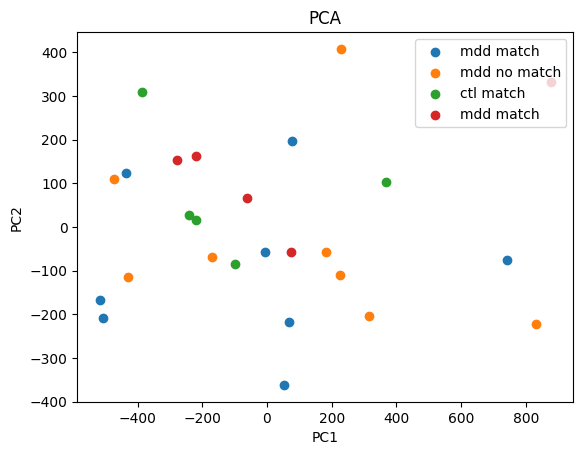

In [307]:
import matplotlib.pyplot as plt

mdd_match = projected_df[projected_df['Match'].astype(bool) & (projected_df['subject_type'] == 'mdd')]
mdd_no_match = projected_df[~projected_df['Match'].astype(bool) & (projected_df['subject_type'] == 'mdd')]
ctl_match = projected_df[projected_df['Match'].astype(bool) & (projected_df['subject_type'] == 'ctl')]
ctl_no_match = projected_df[~projected_df['Match'].astype(bool) & (projected_df['subject_type'] == 'ctl')]

plt.title('PCA')
# plt.scatter(, projected_points[:16, 1], color='green', label='mdd')
# plt.scatter(projected_points[16:, 0], projected_points[16:, 1], color='red', label='ctl')
plt.scatter(mdd_match['PC1'], mdd_match['PC2'], label='mdd match')
plt.scatter(mdd_no_match['PC1'], mdd_no_match['PC2'], label='mdd no match')
plt.scatter(ctl_match['PC1'], ctl_match['PC2'], label='ctl match')
plt.scatter(ctl_no_match['PC1'], ctl_no_match['PC2'], label='mdd match')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

In [308]:
from sklearn.manifold import TSNE

seed = 2
perplexity = 5
projected_points = TSNE(n_components=2, random_state=seed, perplexity=perplexity).fit_transform(pivot_df)
projected_df = pd.DataFrame(projected_points, index=pivot_df.index, columns=['TSNE 1', 'TSNE 2']).reset_index()

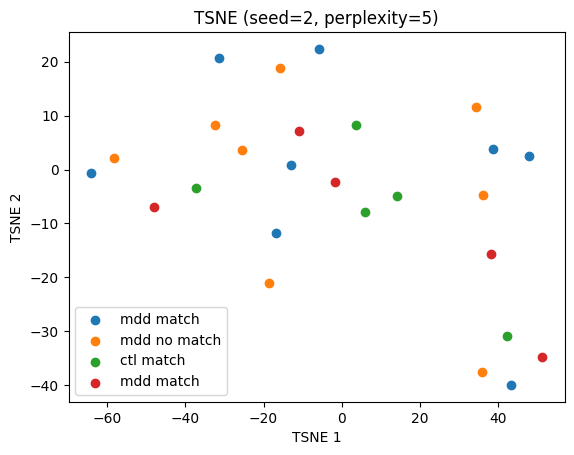

In [309]:
mdd_match = projected_df[projected_df['Match'].astype(bool) & (projected_df['subject_type'] == 'mdd')]
mdd_no_match = projected_df[~projected_df['Match'].astype(bool) & (projected_df['subject_type'] == 'mdd')]
ctl_match = projected_df[projected_df['Match'].astype(bool) & (projected_df['subject_type'] == 'ctl')]
ctl_no_match = projected_df[~projected_df['Match'].astype(bool) & (projected_df['subject_type'] == 'ctl')]

plt.title(f'TSNE (seed={seed}, perplexity={perplexity})')
plt.scatter(mdd_match['TSNE 1'], mdd_match['TSNE 2'], label='mdd match')
plt.scatter(mdd_no_match['TSNE 1'], mdd_no_match['TSNE 2'], label='mdd no match')
plt.scatter(ctl_match['TSNE 1'], ctl_match['TSNE 2'], label='ctl match')
plt.scatter(ctl_no_match['TSNE 1'], ctl_no_match['TSNE 2'], label='mdd match')
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.legend()

In [310]:
si_scores = {
    203: [0.0, 0.0],
    201: [0.0, 0.0],
    204: [0.0, 0.0],
    202: [0.0, 0.0],
    207: [0.0, 0.0],
    206: [0.011904762, 0.0],
    208: [0.077380952, 0.0],
    209: [0.238095238, 0.079365079],
    210: [0.0, 0.0],
    211: [0.0, 0.0],
    212: [0.290000000, 0.080000000],
    306: [0.404761905, 0.174603175],
    307: [0.386904762, 0.063492063],
    308: [0.250000000, 0.0],
    309: [0.0, 0.0],
    310: [0.0, 0.0],
    311: [0.017441860, 0.0],
    313: [0.250000000, 0.079365079],
    314: [0.660714286, 0.301587302],
    315: [0.029761905, 0.015873016],
    316: [0.892857143, 0.317460317],
    317: [0.571428571, 0.0],
    318: [0.0, 0.0],
    320: [0.095238095, 0.023809524],
    321: [0.0, 0.0],
    323: [0.0, 0.0],
    322: [0.086206897, 0.0],
    205: [0.07738095, 0.0],
    301: [0, 0.],
    304: [0, 0.]
}

In [311]:
augmented_df = subject_df
# extract features 
augmented_df['incongruent'] = 1 - augmented_df['Match']
augmented_df['life-block'] = (subject_df['BlockType'] == 'life-me').astype(int)
augmented_df['death-block'] = (subject_df['BlockType'] == 'death-me').astype(int)
# indicator for stim types
augmented_df['me-stim'] = (augmented_df['Stim'].isin(categories['Me'])).astype(int)
augmented_df['not-me-stim'] = (augmented_df['Stim'].isin(categories['Not me'])).astype(int)
augmented_df['life-stim'] = (augmented_df['Stim'].isin(categories['Life'])).astype(int)
augmented_df['death-stim'] = (augmented_df['Stim'].isin(categories['Death'])).astype(int)

# go over all possible block type + stim type combo's
augmented_df['life-block me-stim'] = augmented_df['life-block'] & augmented_df['me-stim']
augmented_df['life-block not-me-stim'] = augmented_df['life-block'] & augmented_df['not-me-stim']
augmented_df['life-block life-stim'] = augmented_df['life-block'] & augmented_df['life-stim']
augmented_df['life-block death-stim'] = augmented_df['life-block'] & augmented_df['death-stim']

augmented_df['death-block me-stim'] = augmented_df['death-block'] & augmented_df['me-stim']
augmented_df['death-block not-me-stim'] = augmented_df['death-block'] & augmented_df['not-me-stim']
augmented_df['death-block life-stim'] = augmented_df['death-block'] & augmented_df['life-stim']
augmented_df['death-block death-stim'] = augmented_df['death-block'] & augmented_df['death-stim']

In [312]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from functools import partial

def get_sig_coef(group, columns):
    x = group[columns].to_numpy()
    x = sm.add_constant(x)
    y = np.log(group['ResponseTime'])
    sm_model = sm.OLS(y, x).fit()
    is_sig = sm_model.pvalues < .05
    return is_sig[1:].astype(int)

def get_param_rt(group, columns):
    x = group[columns].to_numpy()
    x = sm.add_constant(x)
    y = np.log(group['ResponseTime'])
    sm_model = sm.OLS(y, x).fit()
    return sm_model.params[1:]

In [313]:
mdd_df = subject_df[subject_df['subject_type'] == 'mdd']
ctl_df = subject_df[subject_df['subject_type'] == 'ctl']

In [314]:
model_2_cats = ['life-block', 'incongruent']
model_4_cats = ['me-stim', 'not-me-stim', 'life-stim', 'life-block']
model_7_cats = ['life-block me-stim', 'life-block not-me-stim', 'life-block life-stim', 'life-block death-stim', 'death-block me-stim', 'death-block not-me-stim', 'death-block life-stim']
model_life_block = ['life-block']

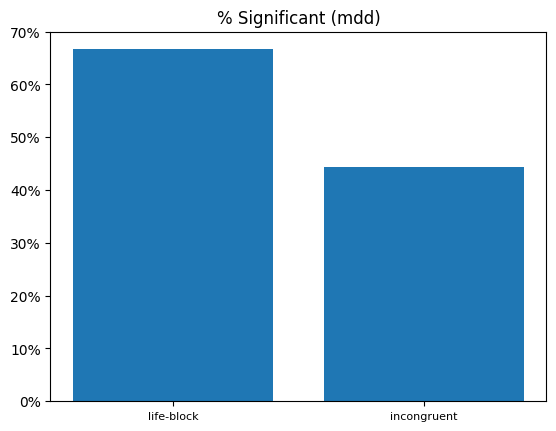

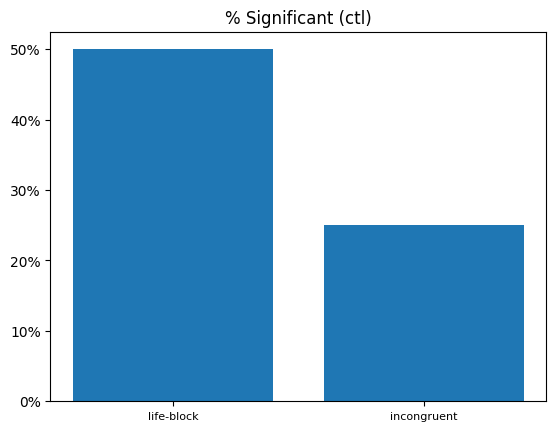

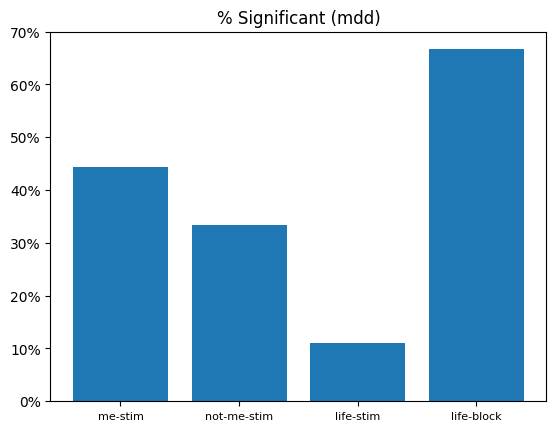

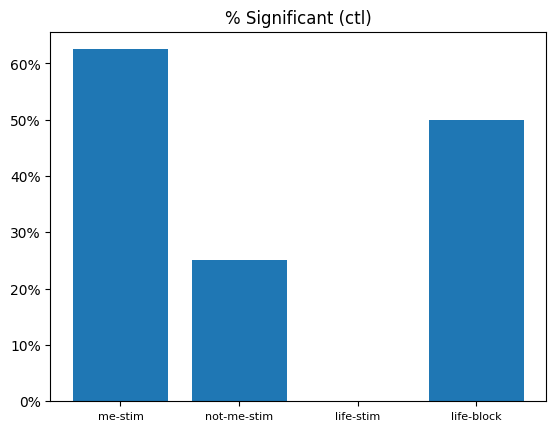

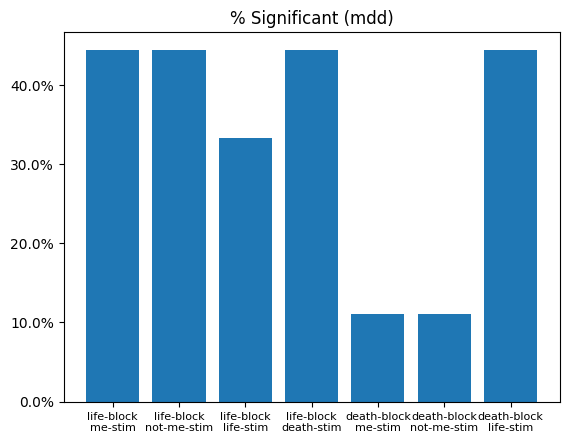

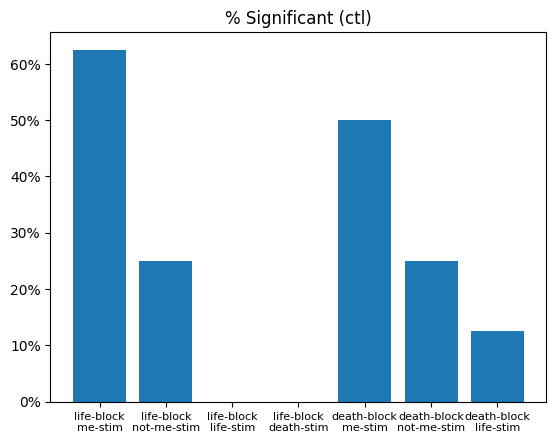

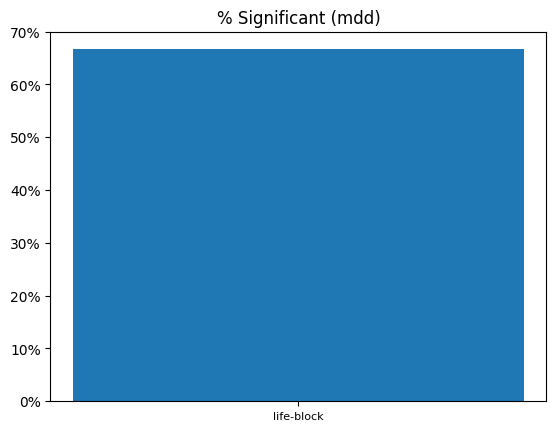

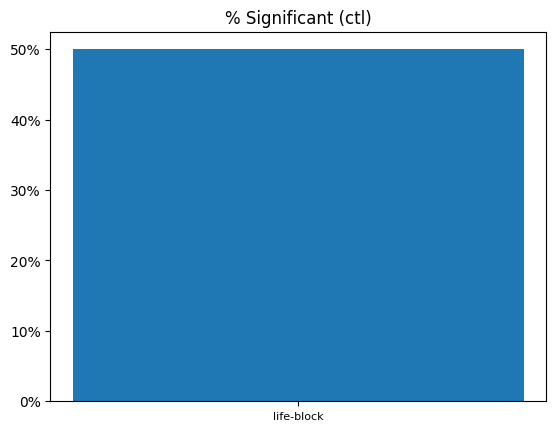

In [315]:
import matplotlib.ticker as mtick

def plot_sig_counts(df, columns, subject_type):
    counts = df.groupby('subject_id').apply(partial(get_sig_coef, columns=columns), include_groups=False).agg('sum')
    counts /= df['subject_id'].nunique()
    counts *= 100
    
    columns_newline = [re.sub('\s', '\n', column) for column in columns]
    plt.bar(columns_newline, counts)
    plt.xticks(fontsize=8)
    plt.title(f'% Significant ({subject_type})')
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
    plt.show()
    
plot_sig_counts(mdd_df, model_2_cats, 'mdd')
plot_sig_counts(ctl_df, model_2_cats, 'ctl')
plot_sig_counts(mdd_df, model_4_cats, 'mdd')
plot_sig_counts(ctl_df, model_4_cats, 'ctl')
plot_sig_counts(mdd_df, model_7_cats, 'mdd')
plot_sig_counts(ctl_df, model_7_cats, 'ctl')
plot_sig_counts(mdd_df, model_life_block, 'mdd')
plot_sig_counts(ctl_df, model_life_block, 'ctl')

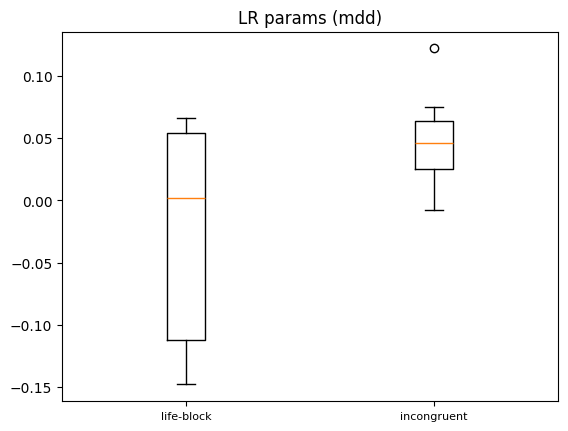

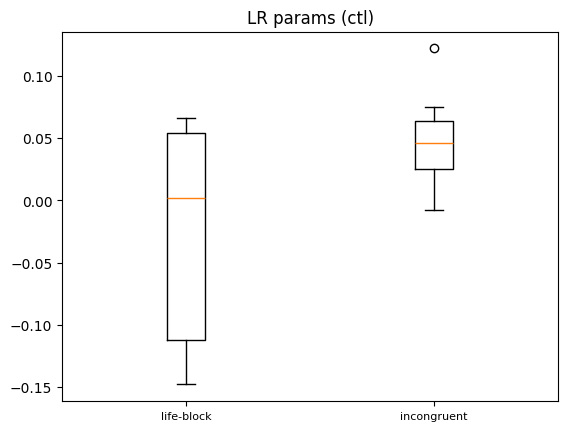

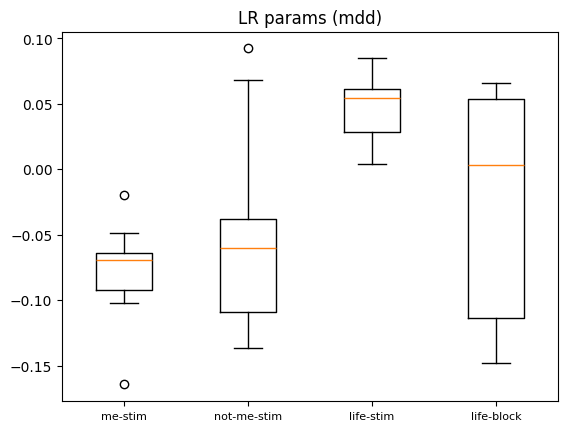

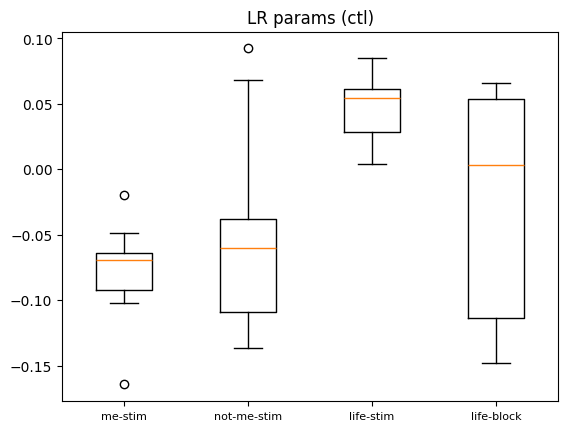

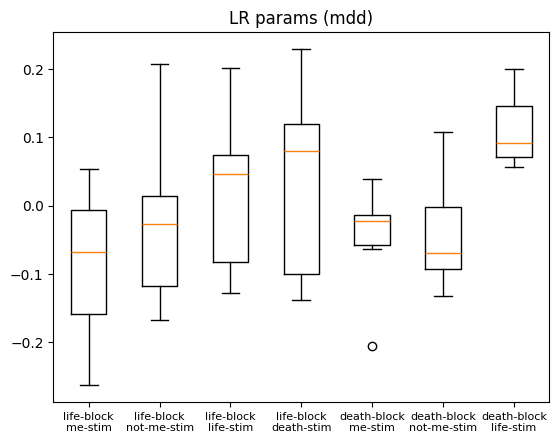

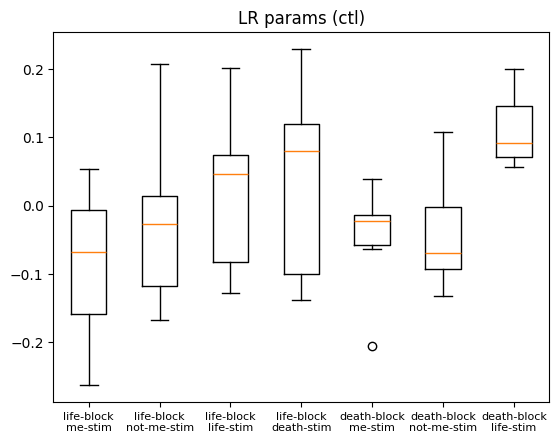

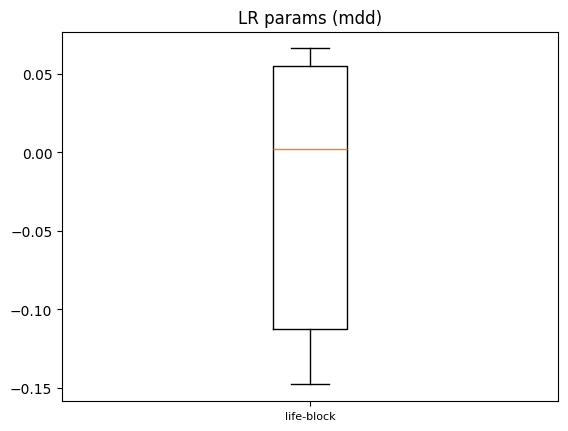

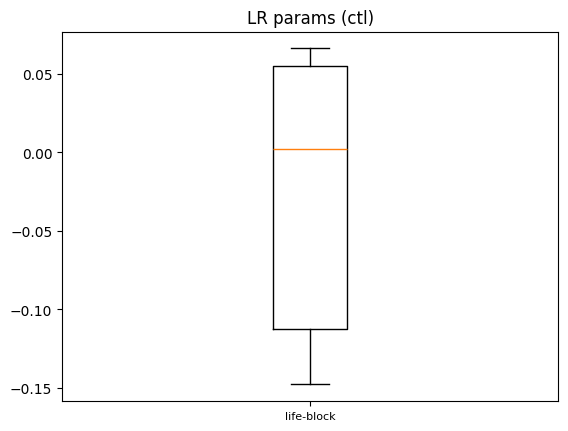

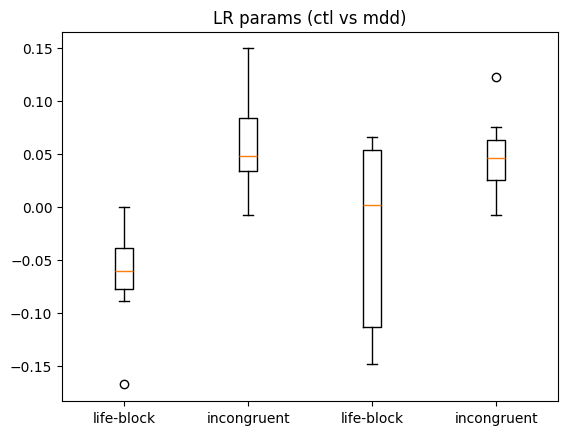

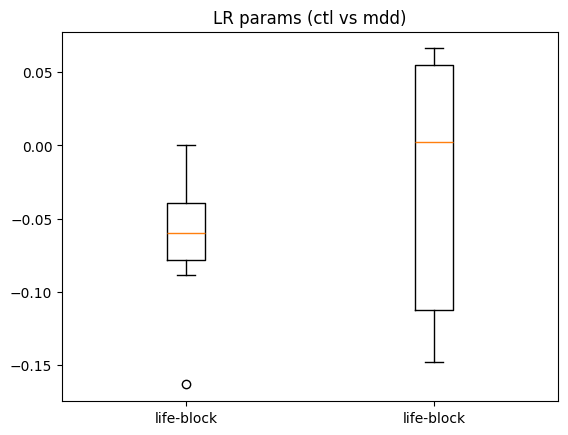

In [316]:
def params_boxplot(df, columns, subject_type):
    params = df.groupby('subject_id').apply(partial(get_param_rt, columns=columns), include_groups=False)
    columns_newline = [re.sub('\s', '\n', column) for column in columns]
    plt.boxplot(params)
    plt.xticks(np.arange(1, len(columns_newline)+1), columns_newline, fontsize=8)
    plt.title(f'LR params ({subject_type})')
    plt.show()
    
def params_boxplot_compare(df1, df2, columns, df1_type, df2_type):
    params1 = df1.groupby('subject_id').apply(partial(get_param_rt, columns=columns), include_groups=False)
    params2 = df2.groupby('subject_id').apply(partial(get_param_rt, columns=columns), include_groups=False)
    columns_newline = [re.sub('\s', '\n', column) for column in columns] * 2
    plt.boxplot(params1)
    plt.boxplot(params2, positions=np.arange(len(columns) + 1,len(columns_newline) + 1))
    
    plt.xticks(np.arange(1, 2 * len(columns)+1), columns_newline)
    plt.title(f'LR params ({df1_type} vs {df2_type})')
    plt.show()
    
params_boxplot(mdd_df, model_2_cats, 'mdd')
params_boxplot(mdd_df, model_2_cats, 'ctl')
params_boxplot(mdd_df, model_4_cats, 'mdd')
params_boxplot(mdd_df, model_4_cats, 'ctl')
params_boxplot(mdd_df, model_7_cats, 'mdd')
params_boxplot(mdd_df, model_7_cats, 'ctl')
params_boxplot(mdd_df, model_life_block, 'mdd')
params_boxplot(mdd_df, model_life_block, 'ctl')
params_boxplot_compare(ctl_df, mdd_df, model_2_cats, 'ctl', 'mdd')
params_boxplot_compare(ctl_df, mdd_df, model_life_block, 'ctl', 'mdd')

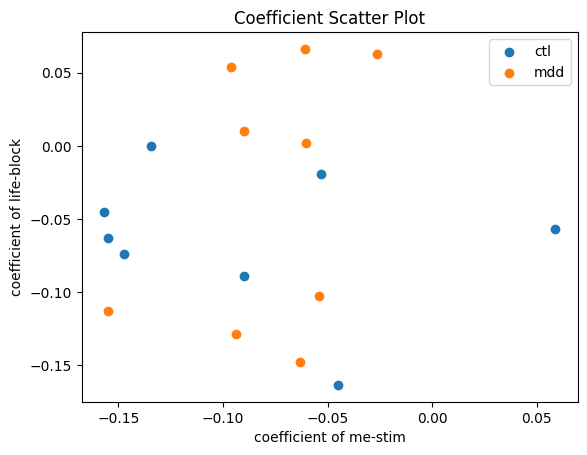

In [317]:
def plot_2d_coef(df1, df2, col1, col2, df1_type, df2_type):
    params1 = df1.groupby('subject_id').apply(partial(get_param_rt, columns=[col1, col2]), include_groups=False)
    params2 = df2.groupby('subject_id').apply(partial(get_param_rt, columns=[col1, col2]), include_groups=False)

    plt.scatter(params1['x1'], params1['x2'], label=df1_type)
    plt.scatter(params2['x1'], params2['x2'], label=df2_type)
    plt.xlabel(f'coefficient of {col1}')
    plt.ylabel(f'coefficient of {col2}')
    plt.title(f'Coefficient Scatter Plot')
    plt.legend()

plot_2d_coef(ctl_df, mdd_df, 'me-stim', 'life-block', 'ctl', 'mdd')


# next thing: try asi/psi
# do logistic regression + decision boundary
# plot each coefficient separately

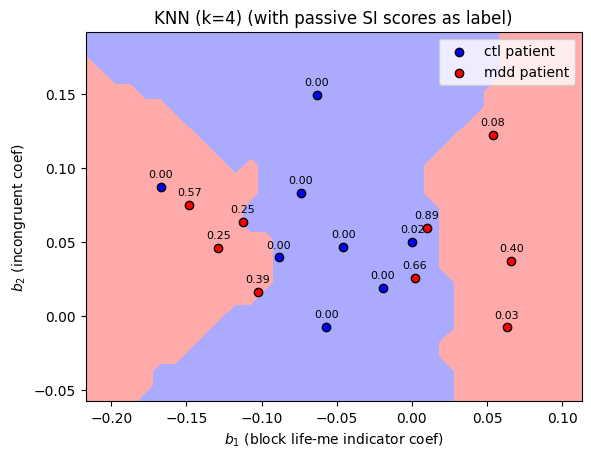

In [362]:
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
import statsmodels.api as sm
import numpy as np 


params = subject_df.groupby(['subject_id', 'subject_type']).apply(partial(get_param_rt, columns=['life-block', 'incongruent']), include_groups=False).reset_index()
n_neighbors = 4
knn = KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(params[['x1', 'x2']].to_numpy(), params['subject_type'])

x_min = params['x1'].min() - .05
x_max = params['x1'].max() + .05

y_min = params['x2'].min() - .05
y_max = params['x2'].max() + .05

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_bold = ['#FF0000', '#0000FF']


plt.contourf(xx, yy, Z == 'ctl', cmap=cmap_light)

ctl_params = params[params['subject_type'] == 'ctl']
mdd_params = params[params['subject_type'] == 'mdd']
plt.scatter(ctl_params['x1'], ctl_params['x2'], label='ctl patient', edgecolor='k', color='blue')
plt.scatter(mdd_params['x1'], mdd_params['x2'], label='mdd patient', edgecolor='k', color='red')

for i, row in params.iterrows():
    psi_score = si_scores[int(row['subject_id'])][0]
    plt.text(row['x1'], row['x2'] + .005, f'{psi_score:.2f}',fontsize='8', ha='center', va='bottom')    
    
plt.xlabel('$b_1$ (block life-me indicator coef)')
plt.ylabel('$b_2$ (incongruent coef)')
plt.title(f'KNN (k={n_neighbors}) (with passive SI scores as label)')
plt.legend()